In [1]:
#importing lib
import pandas as pd
import numpy as np
#reading dataset
dataset = pd.read_csv("age_gender.csv")

In [2]:
dataset['pixels']=dataset['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))/255

In [3]:
#removing the column img_name because not relevant for the study
dataset=dataset.drop('img_name',axis=1)


## Image samples

In [4]:
import matplotlib.pyplot as plt # plotting
from math import *

def sample(xs):
  num=len(xs)
  num_row = ceil(num/5)
  num_col = num if num<5  else 5

  # plot images
  fig, axes = plt.subplots(num_row, num_col, figsize=(6*num_col,6*num_row))


  for x,i in zip(xs,[i for i in range(num)]):
    
    img = np.asarray(dataset.loc[x,"pixels"]).reshape(48, 48)
    titre = "age : " + str(dataset.loc[x,'age']) +" ethnie : "+ str(dataset.loc[x,'ethnicity'])+ " genre : "+ str(dataset.loc[x,'gender'])
    ax = axes[i//num_col, i%num_col]
    ax.imshow(img,cmap='gray', vmin=0, vmax=1)
    ax.set_title(titre,fontsize=24)

  plt.tight_layout()
  plt.show()


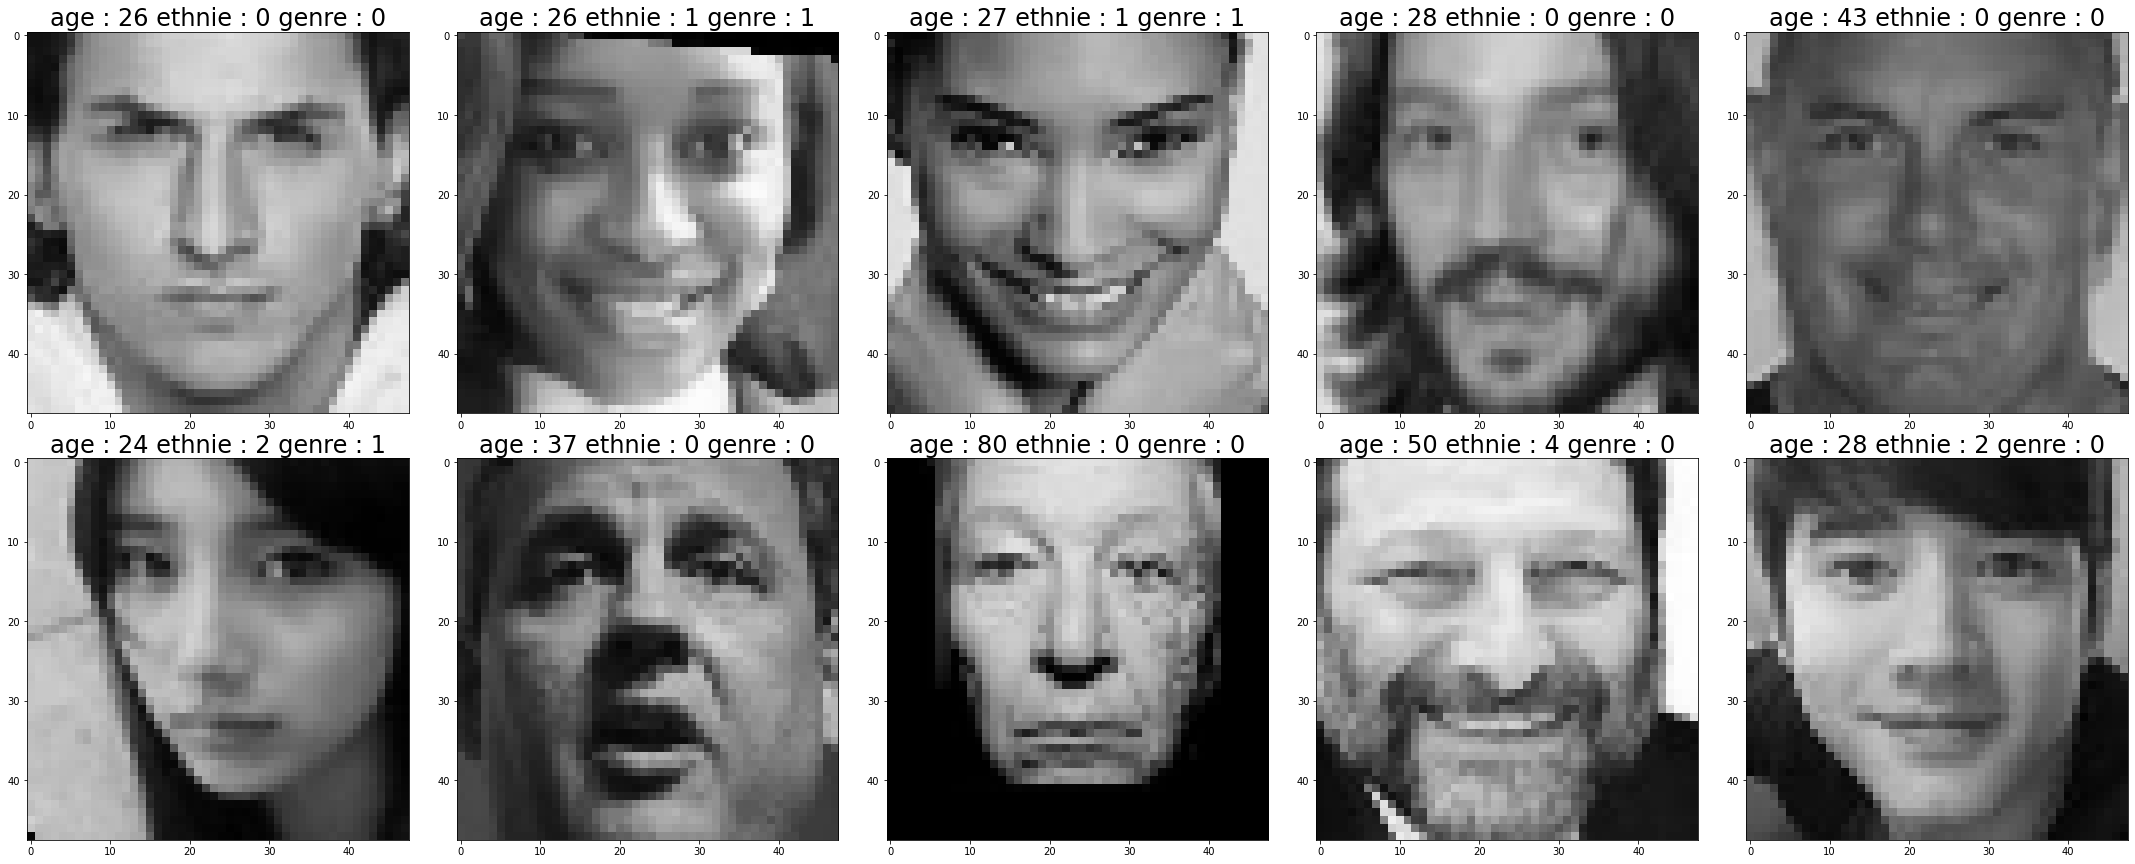

In [5]:
#the code allows to extract a batch of 10 images randomly from the dataset
import random
#sample([i for i in range(10)])
sample([random.randint(0,len(dataset)) for i in range(10)])

# EDA

In [6]:
import seaborn as sns

<AxesSubplot:xlabel='ethnicity', ylabel='count'>

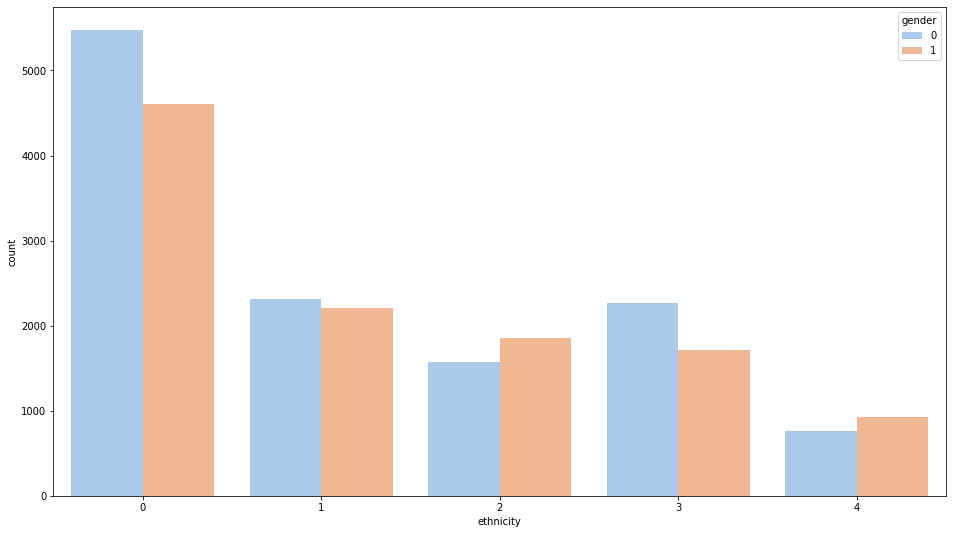

In [7]:
plt.figure(figsize=(16,9))
sns.set_palette("pastel")
sns.countplot(x ='ethnicity',hue="gender", data = dataset) 

the ethnicity variable is unbalanced with an over-representation of category 1. It will be interesting to see the capacity of our model to correctly predict under-represented categories via a confusion matrix. On the other hand, the genders are well balanced within each ethnic group.

<AxesSubplot:xlabel='gender', ylabel='count'>

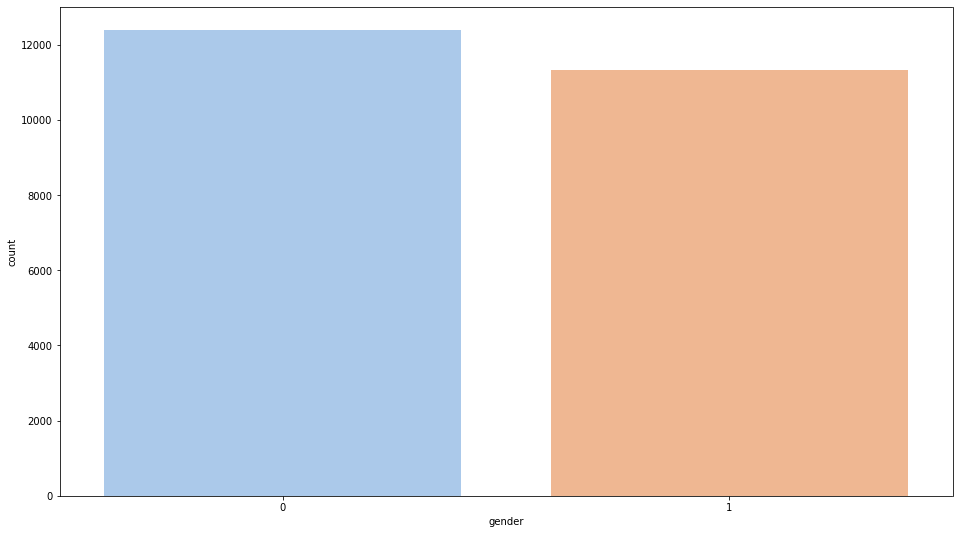

In [8]:
plt.figure(figsize=(16,9))
sns.set_palette("pastel")
sns.countplot(x ='gender', data = dataset) 

c:\users\nayanika singh\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\nayanika singh\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


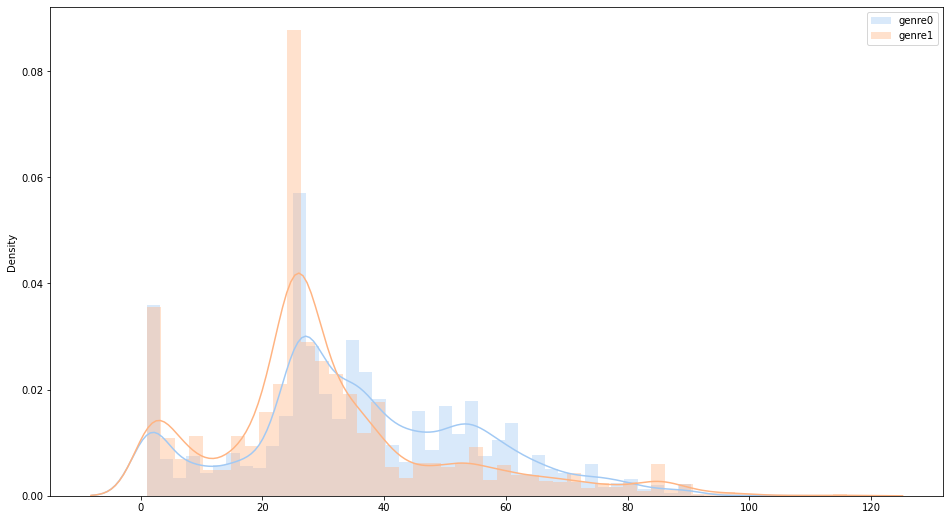

In [9]:
plt.figure(figsize=(16,9))
sns.distplot(dataset.loc[dataset.gender==0,["age"]],bins=50,label="genre0")
sns.distplot(dataset.loc[dataset.gender==1,["age"]],bins=50,label="genre1")
plt.legend()

# Data Split

In [10]:
X=dataset['pixels']

In [11]:
X_t = []
for i in range(X.shape[0]):
    X_t.append(X[i].reshape(48,48,1)) #reshaping the data to (n,48,48,1)
X = np.array(X_t)

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_test, y_train_gender, y_test_gender, y_train_ethnicity, y_test_ethnicity, y_train_age, y_test_age = train_test_split(
    X,pd.get_dummies(dataset['gender']).values,pd.get_dummies(dataset['ethnicity']).values,dataset['age'].values,test_size=0.1, random_state=1234)

In [13]:
x_val, x_test, y_val_gender, y_test_gender, y_val_ethnicity, y_test_ethnicity, y_val_age, y_test_age = train_test_split(
    x_test, y_test_gender, y_test_ethnicity, y_test_age,test_size=0.5, random_state=1234)

# Model Build

In [14]:
!pip install -U keras-tuner

You should consider upgrading via the 'c:\users\nayanika singh\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.



  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9562 sha256=de441fc1437c6d5a9e7c6e4d947c8587a99fdcc89889a95916d7195b523fd601
  Stored in directory: c:\users\nayanika singh\appdata\local\pip\cache\wheels\a8\67\9d\0dece28e14096b9ef4403317a090c3bfe1dc6a4d0a1287360a
Successfully built kt-legacy


In [16]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import clone_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import keras
import IPython

In [17]:
def build_model(hp):
    inputs = tf.keras.Input(shape=(48, 48, 1))
    x = inputs
    for i in range(hp.Int('conv_blocks', 3, 5, default=3)):
        filters = hp.Int('filters_' + str(i), 32, 256, step=32)
        for _ in range(2):
            x = tf.keras.layers.Convolution2D(
              filters, kernel_size=(3, 3), padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.LeakyReLU(hp.Float('alpha', 0, 0.3, step=0.01, default=0.01))(x)
            #x = tf.nn.leaky_relu(model, alpha=0.01, name='Leaky_ReLU')
            #x = tf.keras.layers.ReLU()(x)
        if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
            x = tf.keras.layers.MaxPool2D()(x)
        else:
            x = tf.keras.layers.AvgPool2D()(x)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=1024,
                                        step=32),
                           activation='relu')(x)
    x = tf.keras.layers.Dropout(
        hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
    x = layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=1024,
                                        step=32),
                           activation='relu')(x)

    out_gender = layers.Dense(2, activation='sigmoid', name='gender_out')(x) ## output binaire
    out_ethnicity = layers.Dense(5, activation='softmax', name='ethnicity_out')(x) ## output catégoriel
    out_age=layers.Dense(1, name='age_out')(x) ## output continue

    model = tf.keras.Model(inputs=inputs, outputs=[out_gender, out_ethnicity, out_age])

    model.compile(
      optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss={'gender_out':'BinaryCrossentropy',
              'ethnicity_out':'categorical_crossentropy',
              'age_out':'mse'},
        metrics={'gender_out':'accuracy',
                 'ethnicity_out':'accuracy',
                 'age_out':'mae'})
    return model

## Instantiate the tuner and perform hypertuning

In [18]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=40,
    #hyperband_iterations=2,
    #seed=1234,
    directory = '..\kaggle\working\',
    project_name = 'Keras_tuning')

## callback to clear the training outputs at the end of every training step

In [19]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [23]:
tuner.search(x_train, {'gender_out': y_train_gender, 'ethnicity_out': y_train_ethnicity, 'age_out': y_train_age},
             validation_data=(x_val, [y_val_gender, y_val_ethnicity, y_val_age]),
             callbacks= [ClearTrainingOutput()])


Search: Running Trial #3

Hyperparameter    |Value             |Best Value So Far 
conv_blocks       |5                 |?                 
filters_0         |160               |?                 
alpha             |0.16              |?                 
pooling_0         |max               |?                 
filters_1         |160               |?                 
pooling_1         |avg               |?                 
filters_2         |64                |?                 
pooling_2         |avg               |?                 
units             |672               |?                 
dropout           |0.4               |?                 
learning_rate     |0.00023611        |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |3                 |?                 
tuner/round       |0                 |?                 
filters_3         |32                |?                 
pool

NotFoundError: Failed to create a NewWriteableFile: ../kaggle/working/Keras_tuning\trial_c7b13edc0e38c26b3084ca4f24e5f833\checkpoints\epoch_0\checkpoint_temp/part-00000-of-00001.data-00000-of-00001.tempstate147577464462052151 : The system cannot find the path specified.
; No such process [Op:SaveV2]

In [22]:
#best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

IndexError: list index out of range

In [ ]:
#best model
best_model = tuner.hypermodel.build(best_hps)

best_model.summary()

# Build the model with the optimal hyperparameters and train it on the data

In [ ]:
batch_size = 32
epochs = 47


history_list = []

In [ ]:
history = best_model.fit(x_train, {'gender_out': y_train_gender, 'ethnicity_out': y_train_ethnicity, 'age_out': y_train_age},
                         batch_size=batch_size,
                         epochs = epochs, validation_data = (x_val, [y_val_gender, y_val_ethnicity, y_val_age]),
                         steps_per_epoch=(x_train.shape[0] // batch_size)
                         )

history_list.append(history)

In [ ]:
from matplotlib import pyplot as plt

def plot_loss(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['gender_out_loss'], label='train_gender_loss')
    plt.plot(np.arange(0, epoch), his.history['ethnicity_out_loss'], label='train_ethnicity_loss')
    plt.plot(np.arange(0, epoch), his.history['age_out_loss'], label='train_age_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_gender_out_loss'], label='val_train_gender_loss')
    plt.plot(np.arange(0, epoch), his.history['val_ethnicity_out_loss'], label='val_train_ethnicity_loss')
    plt.plot(np.arange(0, epoch), his.history['val_age_out_loss'], label='val_train_age_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
def plot_acc(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['gender_out_accuracy'], label='train_gender_acc')
    plt.plot(np.arange(0, epoch), his.history['ethnicity_out_accuracy'], label='train_ethnicity_accuracy')
        
    plt.plot(np.arange(0, epoch), his.history['val_gender_out_accuracy'], label='val_gender_acc')
    plt.plot(np.arange(0, epoch), his.history['val_ethnicity_out_accuracy'], label='val_ethnicity_accuracy')


    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

def plot_MSE(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['age_out_mae'], label='train_age_mae')
    plt.plot(np.arange(0, epoch), his.history['val_age_out_mae'], label='val_age_mae')

    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Mean Absolute Error')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
    plot_loss(history_list[0], epochs, f'Training Dataset: {0}')
    plot_acc(history_list[0], epochs, f'Training Dataset: {0}')
    plot_MSE(history_list[0], epochs, f'Training Dataset: {0}')

In [ ]:
pred = best_model.predict(x_test)

test_loss,test_gender_loss, test_ethnicity_loss, test_age_loss, test_gender_acc,test_ethnicity_acc,test_age_mae = best_model.evaluate(x_test, [y_test_gender, y_test_ethnicity, y_test_age], verbose=0)
print(f'\nTest gender accuracy: {test_gender_acc}')
print(f'\nTest ethnicity accuracy: {test_ethnicity_acc}')
print(f'\nTest age MAE: {test_age_mae}')

In [ ]:
#Confution Matrix and Classification Report Gender

from sklearn.metrics import classification_report, confusion_matrix
Y_pred_gender = np.argmax(pred[0],axis=1)
Y_true_gender = np.argmax(y_test_gender,axis = 1)
print('Confusion Matrix')
print(confusion_matrix(Y_true_gender, Y_pred_gender))
print('Classification Report')
target_names = ['Woman', 'Man']
print(classification_report(Y_true_gender, Y_pred_gender, target_names=target_names))

In [ ]:
#Confution Matrix and Classification Report Ethnicity

from sklearn.metrics import classification_report, confusion_matrix
Y_pred_Ethn = np.argmax(pred[1],axis=1)
Y_true_ethnicity = np.argmax(y_test_ethnicity,axis = 1)
print('Confusion Matrix')
print(confusion_matrix(Y_true_ethnicity, Y_pred_Ethn))
print('Classification Report')
target_names = ['0', '1','2','3','4']
print(classification_report(Y_true_ethnicity, Y_pred_Ethn, target_names=target_names))

In [ ]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 10 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(20, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((48,48)),cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.show()

## gender error

In [ ]:
Y_pred_gender = np.argmax(pred[0],axis=1)
Y_true_gender = np.argmax(y_test_gender,axis = 1)

In [ ]:
errors_gender = (Y_pred_gender - Y_true_gender != 0)

In [ ]:
Y_pred_gender_class_errors = Y_pred_gender[errors_gender]
Y_pred_gender_errors = pred[0][errors_gender]
Y_true_errors = Y_true_gender[errors_gender]
x_val_errors = x_test[errors_gender]

In [ ]:
Y_pred_gender_errors_prob = np.max(Y_pred_gender_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(Y_pred_gender_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_gender_errors_prob - true_prob_errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_dela_errors[-10:]

display_errors(most_important_errors, x_val_errors, Y_pred_gender_class_errors, Y_true_errors)

## ethnicity error

In [ ]:
Y_pred_ethnicity = np.argmax(pred[1],axis=1)
Y_true_ethnicity = np.argmax(y_test_ethnicity,axis = 1)

In [ ]:
errors_ethnicity = (Y_pred_ethnicity - Y_true_ethnicity != 0)

In [ ]:
Y_pred_ethnicity_class_errors = Y_pred_ethnicity[errors_ethnicity]
Y_pred_ethnicity_errors = pred[1][errors_ethnicity]
Y_true_ethnicity_errors = Y_true_ethnicity[errors_ethnicity]
x_test_ethnicity_errors = x_test[errors_ethnicity]

In [ ]:
Y_pred_ethnicity_errors_prob = np.max(Y_pred_ethnicity_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(Y_pred_ethnicity_errors, Y_true_ethnicity_errors, axis=1))
delta_pred_true_ethnicity_errors = Y_pred_ethnicity_errors_prob - true_prob_errors
sorted_delta_ethnicity_errors = np.argsort(delta_pred_true_ethnicity_errors)
most_important_errors = sorted_delta_ethnicity_errors[-10:]

display_errors(most_important_errors, x_test_ethnicity_errors, Y_pred_ethnicity_class_errors, Y_true_ethnicity_errors)

## Age error

In [ ]:
Y_pred_age = np.around(pred[2]).reshape(pred[2].size)
Y_true_age = y_test_age

In [ ]:
MSE_age =np.sqrt((Y_pred_age-Y_true_age)**2)

In [ ]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)


In [ ]:
Max_MSE_age=largest_indices(MSE_age, 10)[0]

In [ ]:
display_errors(Max_MSE_age, x_test, Y_pred_age, Y_true_age)